# Feature selection with Variance Thresholding

* Important to select features of a dataset without losing predictive power
* Datasets may have hundreds or thousands of features but too many features may be redundant or add little predictive power
* Explore a technique called Variance Thresholding


### What is variance?

* A single metric that describes the variability of a distribution
* It shows how spread out the distribution is
* Measures the average squared distance from the mean
* ![Alt text](image.png)
* Any feature or distribution with close to zero variance should be eliminated

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
def select_features_using_variance(df: pd.DataFrame, threshold=0):
    vt = VarianceThreshold(threshold)
    _ = vt.fit(df)

    print(f"Feature selection using variance = {threshold}")
    print(f"Number of features BEFORE = {df.shape[1]}")

    # Apply boolean mask to retain only features that are above the threshold
    mask = vt.get_support()  
    df = df.loc[:, mask]
    print(f"Number of features AFTER = {df.shape[1]}")
    return df


def extract_named_features(df: pd.DataFrame, column_label, var_name, value_name):
    # We only want columns that measured the buttock area
    col_names = [col for col in df.columns if column_label in col]
    df_name = df.loc[:, col_names]
    df_name_tall = pd.melt(df_name,
                           value_vars = col_names,
                           var_name = var_name,
                           value_name = value_name,
                           ignore_index = False)
    return df_name_tall


def build_forest_regressor_model(df: pd.DataFrame):
    # Build feature, target arrays
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    # Init, fit, score
    forest = RandomForestRegressor(random_state = 42)

    _ = forest.fit(X_train, y_train)

    # Training and test scores
    print(f"Training Score: {forest.score(X_train, y_train):.3f}")
    print(f"Test Score: {forest.score(X_test, y_test):.3f}")

### Load Ansur data

* Dataset has 108 features
* 99 features are numerical
* We can only apply variance thresholding to numerical features

In [3]:
FILE_PATH = '/workspaces/feature_selection/data/'
ansur = pd.read_csv(FILE_PATH + 'ANSUR II MALE Public.csv', encoding="Latin")
print(f"Ansur dataset {ansur.shape}")

# Numerical features only
ansur_numerical = ansur.select_dtypes(include='number')
print(f"Ansur dataset (numerical features only) {ansur_numerical.shape}")

Ansur dataset (4082, 108)
Ansur dataset (numerical features only) (4082, 99)


### Remove features with zero variance

* We fit the estimator `VarianceThreshold` to the data
* Call its `get_support()` method
* This returns a boolean mask with `True` values for columns which are not dropped
* We use this mask to drop columns with zero variance
* However, there are no feature columns with zero variance as we still have 99 columns


In [4]:
ansur_numerical = select_features_using_variance(ansur_numerical)

Feature selection using variance = 0
Number of features BEFORE = 99
Number of features AFTER = 99


### Remove features with close to zero variance

* With a threshold of 1, we only drop 1 column
* The number of columns went from 99 to 98

In [5]:
ansur_numerical = select_features_using_variance(ansur_numerical, threshold=1)

Feature selection using variance = 1
Number of features BEFORE = 99
Number of features AFTER = 98


### Feature normalization

* Often cannot compare the variance of one feature with another 
* This is due to different value ranges

In [6]:
ansur_buttock_tall = extract_named_features(ansur, column_label='buttock', var_name = 'length', value_name = 'Length (mm)')

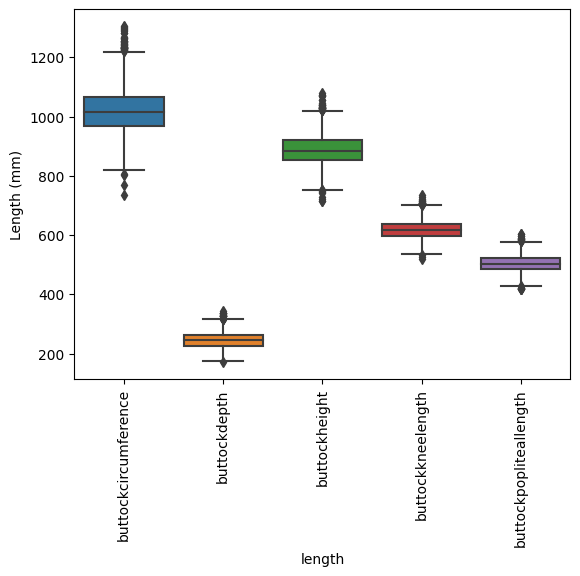

In [7]:
ansur_plot = sns.boxplot(x = ansur_buttock_tall["length"],
                         y = ansur_buttock_tall["Length (mm)"] )
ansur_plot.set_xticklabels(ansur_plot.get_xticklabels(), rotation=90)
plt.show()

* All of our features have different medians, quartiles, and ranges
* They are not comparable to one another
* We can normalize our features by dividing by the mean of each feature

In [8]:
# Normalize all Ansur numerical features
ansur_normalized = ansur_numerical / ansur_numerical.mean()
ansur_normalized.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,SubjectNumericRace,Age,Heightin,Weightlbs
0,0.501266,1.044567,1.018229,1.005237,0.967978,1.013481,1.003900,1.005300,0.964694,1.030336,...,1.009373,1.135066,0.997648,0.952949,0.994789,1.006476,0.111439,1.359462,1.013768,0.957422
1,0.501515,0.914978,0.968255,0.972425,0.959258,0.972852,0.972156,0.960509,0.947854,0.943776,...,0.946287,0.957067,0.997648,0.848885,0.949313,0.961639,0.111439,1.160516,0.970932,0.851042
2,0.501565,1.127033,0.992548,1.017168,1.002861,0.998433,1.015804,0.975439,1.027243,1.139233,...,1.072459,1.060254,0.985343,1.086245,1.023212,0.980518,0.222877,1.392620,0.970932,1.090397
3,0.504515,0.918905,0.934938,0.924698,1.002861,0.932222,1.039612,0.990370,0.964694,1.002413,...,0.862173,1.029298,0.916246,0.928395,1.000473,0.935681,0.111439,1.027886,0.942376,0.930827
4,0.504565,0.981736,1.100131,1.109638,1.076985,1.112046,1.059452,1.114788,1.046489,0.994037,...,0.900024,0.977704,1.178436,1.106123,1.068688,1.125648,0.222877,0.696310,1.099438,1.132949


### Remove features using a low threshold

* Use the estimator with a lower threshold such as 0.003
* The number of columns went from 99 to 48

In [9]:
ansur_normalized = select_features_using_variance(ansur_normalized, threshold=0.003)

Feature selection using variance = 0.003
Number of features BEFORE = 98
Number of features AFTER = 48


### Compare models

* We trained a Random Forest Regressor to predict a person's weight in pounds
* The model predicted for:
  * Feature-selected data (48 features from 99)
  * Full numerical data (99 features)
* They had identical training scores (0.988)
* The feature selected dataset had a slightly lower test score (0.952 vs. 0.954)

| Model                            | Features  | Train score  | Test score |
|----------------------------------|-----------|--------------|------------|
| Ansur (feature selection)        | 48        | 0.988        | 0.952      |
| Ansur (full numerical features)  | 99        | 0.988        | 0.954      |

In [15]:
build_forest_regressor_model(ansur_normalized)
build_forest_regressor_model(ansur_numerical)

Training Score: 0.988
Test Score: 0.952
Training Score: 0.988
Test Score: 0.954
